In [96]:
import pandas as pd
import scipy
attributes = pd.read_csv('/mnt/distvol/5000Attributes.csv')
#skills = pd.read_csv('/mnt/distvol/5000Skills.csv')

In [97]:
from sklearn.preprocessing import PowerTransformer

def testNormal (x):    
    
    k2, p = stats.normaltest(x)
    alpha = .001
    #print("p = {:g}".format(p))    
    if p < alpha:  # null hypothesis: x comes from a normal distribution
        #print(p)
        #print(alpha)
        print("The null hypothesis can be rejected")
        xt, _ = stats.yeojohnson(x)
        #xt, _ = stats.boxcox(x)        
        print(_)
        xt = pd.DataFrame(xt)
        
        return _, pd.DataFrame(xt).set_index(x.index)
    else:
        print("The null hypothesis cannot be rejected")    
        return 1, pd.DataFrame(x)

def inverse_boxcox (data, lambdas):
    power = PowerTransformer(method='yeo-johnson')
    power.lambdas_ = lambdas.values
    return(power.inverse_transform([data]))
    #return inv_boxcox(data, lambdas.values)
    
def transform_boxcox_l(data, l_):
    transformed = pd.DataFrame()

    for i in range(0,len(data.columns)):
        #print(i)
        if l_.iloc[i].values == 1:
            inner_scale = data.iloc[:,i]            
        else:
            inner_scale = pd.DataFrame(stats.yeojohnson((data.iloc[:,i]), lmbda=l_.iloc[i].values))
            
        inner_scale.index = data.index
        transformed = pd.concat([transformed,inner_scale],axis=1)
        
    transformed.columns = data.columns
    return transformed

def transform_boxcox (data):
    transformed = pd.DataFrame()
    transformed_lambdas = pd.DataFrame()

    for i in range(0,len(data.columns)):
        l, inner_scale = testNormal(data.iloc[:,i])
        inner_scale.set_index(data.index)

        transformed_lambdas = pd.concat([transformed_lambdas,pd.DataFrame(pd.Series(l))],axis=0)
        transformed = pd.concat([transformed,inner_scale],axis=1)
        
    transformed.columns = data.columns
    return transformed, transformed_lambdas

def inverse_yeo(og, data_, lambda_):
    values = []
    for i in range(0,len(og)):
        X = og[i]
        X_trans = data_[i]
        if X >= 0 and lambda_ == 0:
            X = exp(X_trans) - 1
        elif X >= 0 and lambda_ != 0:
            X = (X_trans * lambda_ + 1) ** (1 / lambda_) - 1
        elif X < 0 and lambda_ != 2:
            X = 1 - (-(2 - lambda_) * X_trans + 1) ** (1 / (2 - lambda_))
        elif X < 0 and lambda_ == 2:
            X = 1 - exp(-X_trans)
        
        values.append(X)
    return(pd.DataFrame(values))


def revert_yeo (og, data_, lambdas):
    reverted = pd.DataFrame()

    for i in range(0,len(data_.columns)):        
        if lambdas.iloc[i].values == 1 :
            revert = data_.iloc[:,i]
        else:
            p#ower = PowerTransformer(method='yeo-johnson')
            #power.lambdas_ = lambdas.iloc[i].values
            #revert = pd.DataFrame(power.inverse_transform([data.iloc[:,i].values]))
            #return inv_boxcox(data, lambdas.values)
            revert = pd.DataFrame(inverse_yeo(og.iloc[:,i].values,data_.iloc[:,i].values, lambdas.iloc[i].values))            
        revert.index = data_.index
        reverted = pd.concat([reverted,revert],axis=1)
        
    reverted.columns = data_.columns
    return reverted


In [98]:
import numpy as np
m = np.median(np.matrix.flatten(np.array((attributes.iloc[:,1:]))))
mad = stats.median_absolute_deviation(np.matrix.flatten(np.array((attributes.iloc[:,1:]))))

<ipython-input-98-d372311e6a9c>:3: DeprecationWarning: `median_absolute_deviation` is deprecated, use `median_abs_deviation` instead!

To preserve the existing default behavior, use
`scipy.stats.median_abs_deviation(..., scale=1/1.4826)`.
The value 1.4826 is not numerically precise for scaling
with a normal distribution. For a numerically precise value, use
`scipy.stats.median_abs_deviation(..., scale='normal')`.

  mad = stats.median_absolute_deviation(np.matrix.flatten(np.array((attributes.iloc[:,1:]))))


In [99]:
m

1108.0

In [100]:
import statistics
from scipy import stats
#statistics.median(skills.iloc[:,1:])
attributes.iloc[:,1:].apply(statistics.median,axis=0)

median_transformed = (attributes.iloc[:,1:]-m)/mad
#(attributes.iloc[:,1:]-attributes.iloc[:,1:].apply(statistics.median,axis=0))/attributes.iloc[:,1:].apply(stats.median_absolute_deviation,axis=0)

transformed_, lambdas = transform_boxcox(pd.DataFrame(np.matrix.flatten(np.array(median_transformed))))



The null hypothesis can be rejected
0.7499028287870247


In [101]:
new = pd.DataFrame(np.array(transformed_).reshape(len(attributes),len(attributes.columns)-1))
new.columns = attributes.iloc[:,1:].columns
new.index = attributes.iloc[:,0]
new

norm_cdf = scipy.stats.norm.cdf(new) # calculate the cdf - also discrete

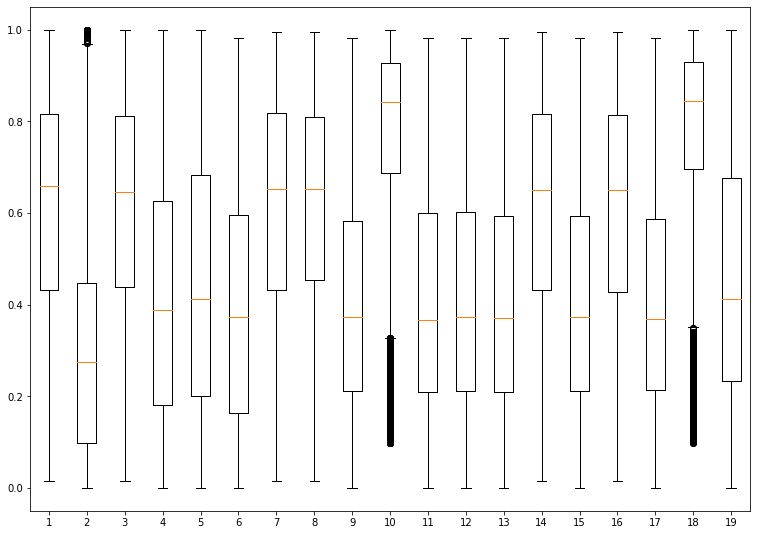

In [111]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize =(10, 7))
ax = fig.add_axes([0, 0, 1, 1])

bp = ax.boxplot(pd.DataFrame(norm_cdf))
plt.show()

In [108]:
display(pd.DataFrame(new,columns=attributes.iloc[:,1:].columns).describe().loc[pd.DataFrame(new).describe().index[1:]].style.background_gradient(cmap ='viridis',axis=None))

display(pd.DataFrame(norm_cdf,columns=attributes.iloc[:,1:].columns).describe().loc[pd.DataFrame(norm_cdf).describe().index[1:]].style.background_gradient(cmap ='viridis',axis=None))

,Strength,Agility,Toughness,Endurance,Recuperation,Disease resistance,Analytical Ability,Creativity,Empathy,Focus,Intuition,Kinesthetic Sense,Linguistic Ability,Memory,Musicality,Patience,Social Awareness,Spatial Sense,Willpower
mean,0.378683,-0.711948,0.370103,-0.292932,-0.121565,-0.390539,0.350647,0.361493,-0.326569,0.969720,-0.337221,-0.308887,-0.324120,0.347398,-0.327093,0.344509,-0.333694,0.987066,-0.071610
std,1.051278,1.082427,1.041942,1.193298,1.386360,1.115471,1.027600,0.990255,1.058760,0.930174,1.061521,1.078576,1.046938,1.029602,1.074018,1.032471,1.071986,0.922318,1.341885
min,-2.181753,-3.318442,-2.181753,-3.130508,-3.130508,-3.130508,-2.181753,-2.181753,-3.126612,-1.290405,-3.130508,-3.130508,-3.130508,-2.181753,-3.130508,-2.178066,-3.130508,-1.290405,-3.130508
25%,-0.171302,-1.290405,-0.153657,-0.909806,-0.840809,-0.976041,-0.173512,-0.115651,-0.798383,0.488107,-0.808154,-0.798383,-0.804896,-0.170565,-0.801639,-0.179411,-0.795129,0.515494,-0.723874
50%,0.408344,-0.599195,0.371923,-0.283766,-0.220899,-0.326089,0.390166,0.390166,-0.326089,1.001662,-0.338241,-0.326089,-0.329125,0.388865,-0.326089,0.384960,-0.332162,1.011060,-0.220899
75%,0.898032,-0.132423,0.881303,0.322074,0.475322,0.242325,0.909360,0.878312,0.210048,1.455395,0.251028,0.258380,0.234276,0.902208,0.234276,0.890271,0.221505,1.470891,0.457372
max,5.682477,5.622118,5.564862,5.591056,5.674330,2.096694,2.601683,2.599707,2.096694,3.087764,2.096694,2.096694,2.098762,2.603658,2.096694,2.603658,2.092557,3.087764,5.706897


,Strength,Agility,Toughness,Endurance,Recuperation,Disease resistance,Analytical Ability,Creativity,Empathy,Focus,Intuition,Kinesthetic Sense,Linguistic Ability,Memory,Musicality,Patience,Social Awareness,Spatial Sense,Willpower
mean,0.608150,0.309593,0.605198,0.421528,0.453539,0.400183,0.604525,0.608822,0.410658,0.765430,0.408858,0.416202,0.410914,0.602954,0.412109,0.602823,0.410783,0.770446,0.461706
std,0.274889,0.244240,0.272322,0.293780,0.310854,0.283391,0.278085,0.269239,0.272985,0.231811,0.275007,0.278935,0.273489,0.278587,0.276628,0.277875,0.274923,0.227485,0.299982
min,0.014564,0.000453,0.014564,0.000873,0.000873,0.000873,0.014564,0.014564,0.000884,0.098455,0.000873,0.000873,0.000873,0.014564,0.000873,0.014701,0.000873,0.098455,0.000873
25%,0.431993,0.098455,0.438940,0.181462,0.200228,0.164522,0.431124,0.453964,0.212324,0.687263,0.209501,0.212324,0.210440,0.432283,0.211381,0.428808,0.213269,0.696896,0.234571
50%,0.658490,0.274522,0.645025,0.388295,0.412586,0.372178,0.651793,0.651793,0.372178,0.841747,0.367591,0.372178,0.371031,0.651312,0.372178,0.649867,0.369884,0.844006,0.412586
75%,0.815416,0.447325,0.810923,0.626302,0.682721,0.595736,0.818420,0.810113,0.583185,0.927220,0.599104,0.601943,0.592615,0.816527,0.592615,0.813340,0.587650,0.929340,0.676298
max,1.000000,1.000000,1.000000,1.000000,1.000000,0.981990,0.995362,0.995335,0.981990,0.998992,0.981990,0.981990,0.982081,0.995388,0.981990,0.995388,0.981806,0.998992,1.000000
